# LDA

### Referencias

- [Twitter Topic Modeling](https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2)
- [Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#18dominanttopicineachsentence)
- [Reddit Machine Learning for Topic Analysis](https://machinelearninghd.com/reddit-machine-learning-sentiment-and-topic-analysis/)

In [1]:
import gensim.corpora as corpora
import nltk, spacy, gensim
import pickle
import numpy as np
from gensim.models import CoherenceModel
import pandas as pd
import pyLDAvis.gensim_models
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
TEXT_FILE_READ = 'docs/preprocessing_reddit_data.csv'
TEXT_SAVE_FILE = 'docs/reddit_data_lda.csv'
FILENAME_PICKLE = "docs/tmpreddit.pickle"

In [3]:
with open(FILENAME_PICKLE, 'rb') as f:
    df = pickle.load(f)
    
#print(df['lemma_tokens'])

In [4]:
# Create Dictionary
id2word = corpora.Dictionary(df['lemma_tokens'])

#print(len(id2word))

# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)

#print(len(id2word))

# Creating a corpus object
corpus = [id2word.doc2bow(d) for d in df['lemma_tokens']]


In [5]:
min_topics = 15
max_topics = 45
step_size = 3
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
result = []

# iterate through number of topics
for a in alpha:
    current = {}

    coherence_values = []
    model_list = []

    # iterate through alpha values
    for k in topics_range:
        # get the coherence score for the given parameters
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                  id2word=id2word,
                                                  num_topics=k,
                                                  random_state=100,
                                                  chunksize=10000,
                                                  passes=10,
                                                  alpha=a,
                                                  per_word_topics=True)

        # Save the model results
        #print('-------------------------------')
        #print('Números de tópicos: ' + str(k))
        #print('Alpha: ' + str(a))

        #print('\nPerplexity: ', lda_model.log_perplexity(corpus))

        coherence_model_lda = CoherenceModel(model=lda_model, texts=df['lemma_tokens'], dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        #print('\nCoherence Score: ', coherence_lda)

        model_list.append(lda_model)
        coherence_values.append(coherence_lda)


    current['coherence_values'] = coherence_values
    current['model_list'] = model_list
    current['alpha'] = a
    result.append(current)

## Selección del número óptimo de tópicos y *alpha* a través de la medida de coherencia

La puntuación de coherencia parece aumentar con la cantidad de tópicos. No siempre es mejor dónde está el *C_v* más alto, por lo que podemos probar varios para encontrar el mejor resultado. Agregar tópicos puede ayudar a revelar más subtópicos. Sin embargo, si las mismas palabras comienzan a aparecer en varios tópicos, la cantidad de tópicos es demasiado alta.

Se revisaron los resultados de diferentes modelos, comenzando por aquellos que tienen el *C_v* más alto. Debido al acomplamiento entre varios tópicos, se descartaron los primeros dos. El tercero se descarto ya que consideré que tenía pocos tópicos y que el cuarto era más interesante en este sentido. Por lo tanto, se seleccionó como hiperparámetros óptimos el número de tópicos 42 y *alpha* 0.01.


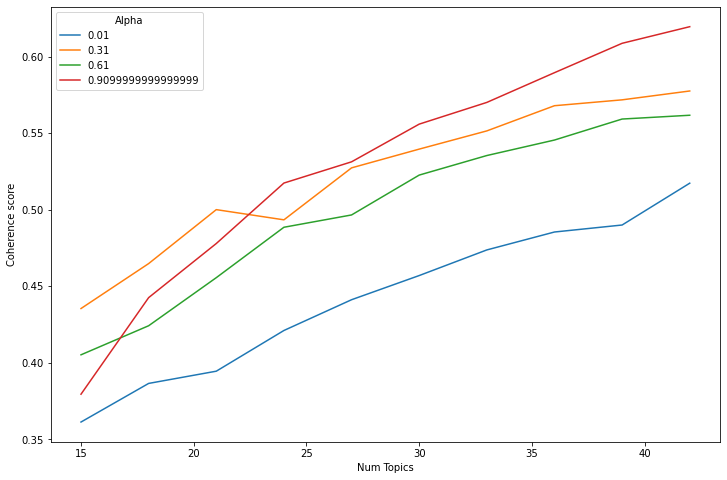

    Alpha  Num Topics  Coherence score
39   0.91          42         0.619534
38   0.91          39         0.608675
37   0.91          36         0.589480
19   0.31          42         0.577524
18   0.31          39         0.571736
36   0.91          33         0.570061
17   0.31          36         0.567902
29   0.61          42         0.561672
28   0.61          39         0.559193
35   0.91          30         0.555869


<Figure size 864x576 with 0 Axes>

In [6]:
plt.figure(figsize=(12, 8))
for current in result:
   plt.plot(topics_range, current['coherence_values'], label=current['alpha'])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(title='Alpha', loc='best')
plt.show()

data = []

plt.figure(figsize=(12, 8))
for current in result:
    for index_num_topic, num_topic in enumerate(topics_range):
        data.append([current['alpha'], num_topic, current['coherence_values'][index_num_topic]])

df = pd.DataFrame(data,columns=['Alpha','Num Topics', 'Coherence score'])
df = df.sort_values(by='Coherence score', ascending=False)
print(df.head(10))

In [16]:
# Instantiating a Base LDA model
base_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                  id2word=id2word,
                                                  num_topics=39,
                                                  random_state=100,
                                                  chunksize=10000,
                                                  passes=10,
                                                  alpha=0.31,
                                                  per_word_topics=True)

In [17]:
for index, topic in base_model.show_topics(num_topics=30, formatted=False, num_words= 30):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))

Topic: 23 
Words: ['venir', 'ganar', 'for', 'video', 'paso', 'debate', 'info', 'link', 'familia', 'feedback', 'removal', 'request', 'dmca', 'savevideo&message=', 'view', 'savevideo)&#32;|&#32;[**donate', 'gracioso', '^(reddit', 'downloader', 'diga', 'paz', 'existir', 'pón', 'exacto', 'vergüenza', 'piedra', 'cringe', 'ajeno', 'ventana', 'correcto']
Topic: 35 
Words: ['político', 'falacia', 'saber', 'historia', 'tratar', 'sistema', 'espert', 'rato', 'cantidad', 'fuerte', 'imagino', 'agarrar', 'jefe', 'zona', 'oficial', 'programa', 'aire', 'osea', 'feo', 'compañero', 'literal', 'parcial', 'obra', 'gil', 'v', 'hornero', 'facultad', 'salio', 'weich', 'copiar']
Topic: 4 
Words: ['votar', 'blanco', 'comida', 'gente', 'algun', 'probar', 'manejar', 'celular', 'él', 'horrible', 'pobreza', 'probablemente', 'jajaj', 'disfrutar', 'deuda', 'chica', 'perdido', 'felicitación', 'juan', 'actual', 'invitar', 'necesita', 'preocupar', 'contexto', 'parte', 'mayorio', 'fútbol', 'chorear', 'entrada', 'complic

In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(base_model, corpus, id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
24    -0.067820 -0.019597       1        1  3.369531
1      0.204825 -0.318177       2        1  3.219832
26     0.071082 -0.021207       3        1  2.795261
8      0.060501  0.030674       4        1  2.774311
23    -0.063204  0.010677       5        1  2.739780
11    -0.103565 -0.077529       6        1  2.707942
14     0.077765  0.072083       7        1  2.684051
37    -0.094689 -0.067548       8        1  2.669352
3      0.107086  0.068574       9        1  2.669118
33    -0.040786 -0.071553      10        1  2.665131
9     -0.111751 -0.010778      11        1  2.663724
36     0.053345  0.089397      12        1  2.627722
15     0.002652  0.057683      13        1  2.613352
38     0.144743  0.093693      14        1  2.606119
25    -0.062634 -0.071383      15        1  2.597256
30     0.004401  0.025283      16        1  2.586655
27     0.099352  0.045844      17        1  2.546327
0     -0.066459 -0.068516      18        1  2.526172
2     -0.035609 -0.111389      19        1  2.513698
5      0.011344  0.028483      20        1  2.512768
34    -0.047947  0.015587      21        1  2.510085
6      0.018632  0.111783      22        1  2.502973
32     0.066178  0.064465      23        1  2.493473
35    -0.034719  0.003543      24        1  2.485907
12    -0.043478  0.035104      25        1  2.483080
10    -0.119411 -0.017200      26        1  2.463156
13    -0.038766 -0.049556      27        1  2.459883
16    -0.022343 -0.009385      28        1  2.451872
7      0.027146  0.085296      29        1  2.445807
18     0.031642  0.052347      30        1  2.441990
4      0.184641 -0.077485      31        1  2.436049
20    -0.052799 -0.005121      32        1  2.433399
21     0.020355 -0.039879      33        1  2.426916
17    -0.061112 -0.018169      34        1  2.371425
19    -0.022098  0.047613      35        1  2.334664
29    -0.026831  0.028439      36        1  2.321986
28    -0.042728  0.039916      37        1  2.302195
31     0.030830  0.046618      38        1  2.292121
22    -0.057772  0.001372      39        1  2.254918, topic_info=           Term         Freq        Total Category  logprob  loglift
223          él  1142.000000  1142.000000  Default  30.0000  30.0000
4243          ⠀   937.000000   937.000000  Default  29.0000  29.0000
4310          ⣿   711.000000   711.000000  Default  28.0000  28.0000
211         año   499.000000   499.000000  Default  27.0000  27.0000
71        pasar   500.000000   500.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
5519     parado    21.939542    23.003678  Topic39  -4.7842   3.7447
566      marcha    19.211781    20.172061  Topic39  -4.9170   3.7433
57    conurbano    18.880552    19.840557  Topic39  -4.9344   3.7425
2636       ahhh    19.237159    20.220845  Topic39  -4.9157   3.7422
1208      vidal    22.831102    60.824842  Topic39  -4.7444   2.8122

[1367 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
763      39  0.988152     +
586      34  0.992356    /s
5361      7  0.929430  2021
3030     12  0.978470  2023
2589     35  0.947951     =
...     ...       ...   ...
4310      1  0.998416     ⣿
4544     36  0.981856     ️
2873      2  0.978839     😂
5098     23  0.960710     😭
2874     20  0.962168     🤣

[1852 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[25, 2, 27, 9, 24, 12, 15, 38, 4, 34, 10, 37, 16, 39, 26, 31, 28, 1, 3, 6, 35, 7, 33, 36, 13, 11, 14, 17, 8, 19, 5, 21, 22, 18, 20, 30, 29, 32, 23])

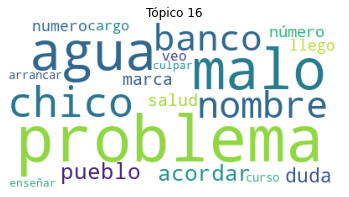

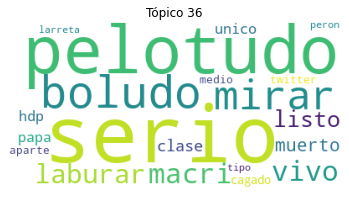

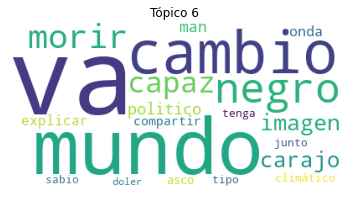

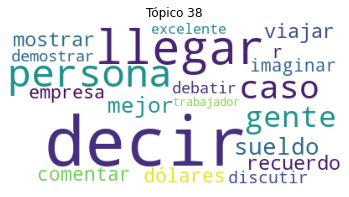

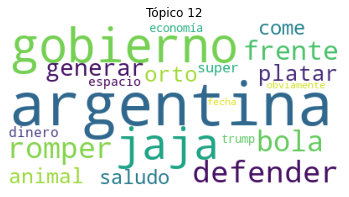

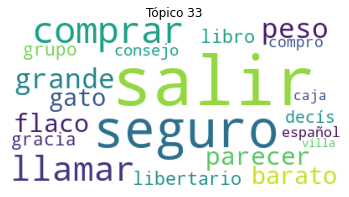

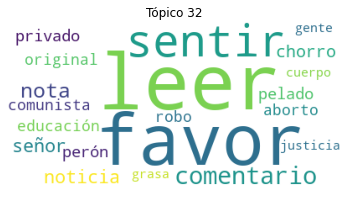

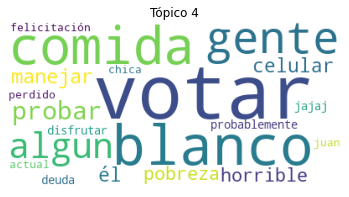

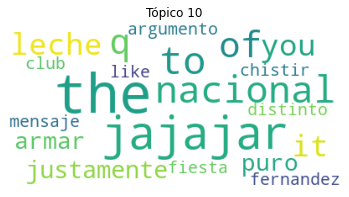

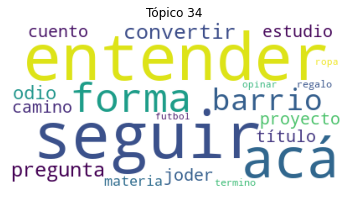

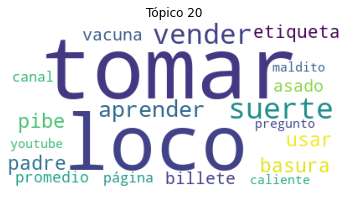

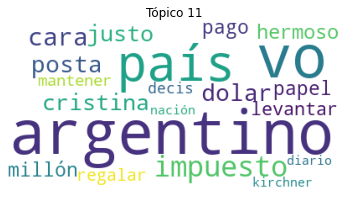

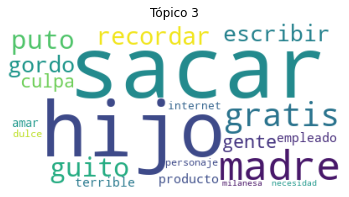

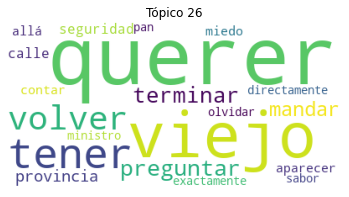

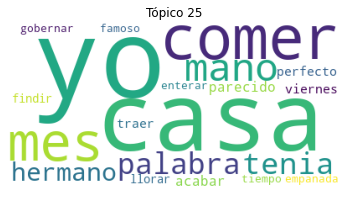

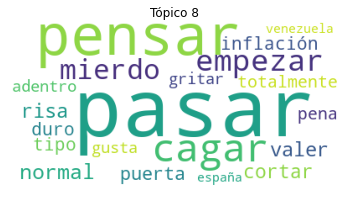

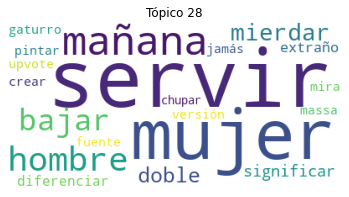

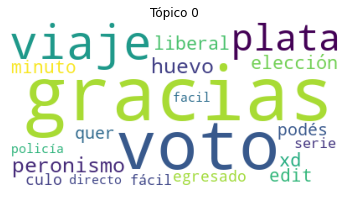

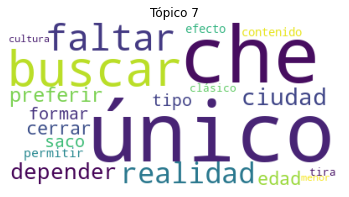

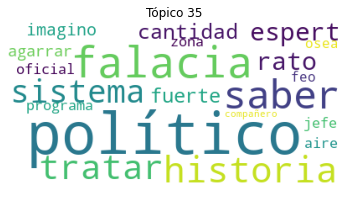

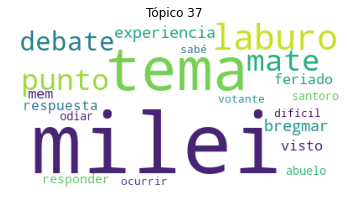

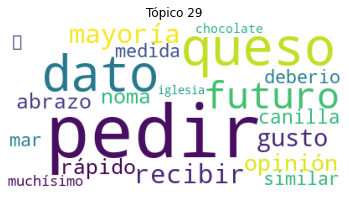

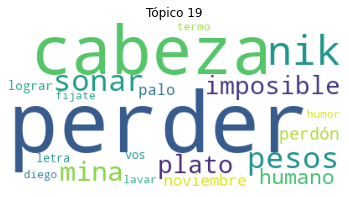

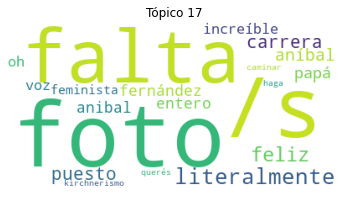

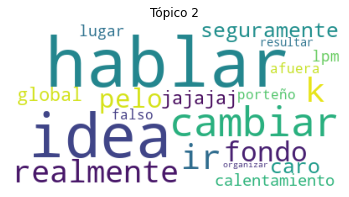

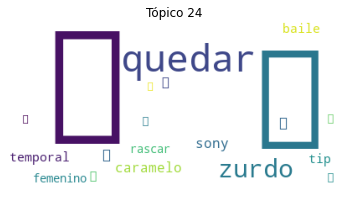

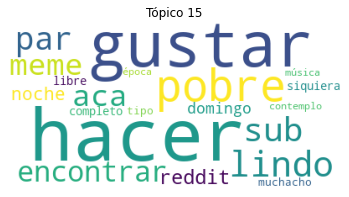

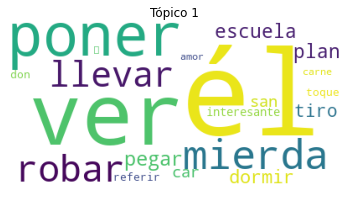

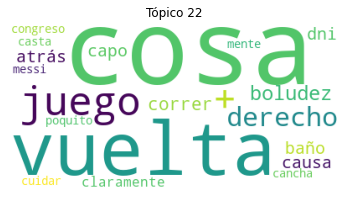

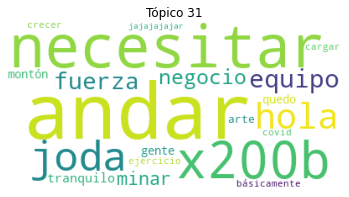

In [19]:
for index, topic in base_model.show_topics(num_topics=30, formatted=False, num_words= 30):
    plt.figure()
    plt.imshow(WordCloud(background_color='white', prefer_horizontal=1.0)
               .fit_words(dict(base_model.show_topic(index, 20))))
    plt.axis("off")
    plt.title("Tópico " + str(index))
    plt.show()

In [21]:
reddit = pd.read_csv(TEXT_FILE_READ)

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # row = sorted(row, key=lambda x: (x[1]), reverse=True) # old line
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                #ent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4)]), ignore_index=True)
                #print(sent_topics_df)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    #sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution']

    # Add original text to the end of the output
    #contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, texts], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=base_model, corpus=corpus, texts=reddit)

In [22]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
#df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,index,Dominant_Topic,Perc_Contribution,Topic_Keywords,score,id,flair,comms_num,body,comment_parent_id,is_replay,body_preprocessing
0,0,19.0,0.1210,"perder, cabeza, nik, pesos, sonar, mina, impos...",1,hgw77qe,Política🏛️,0,"Iba a decir, bue si lo saco de su bolsillo... ...",q9imco,False,bue saco bolsillo recorder hdp mantener alcanz...
1,1,11.0,0.1530,"argentino, vo, país, impuesto, cara, dolar, po...",1,hgw7dci,Política🏛️,0,Se volvio un meme el bot del dolar?,hgw666m,True,volvio meme dolar
2,2,8.0,0.2767,"pasar, pensar, cagar, empezar, mierdo, normal,...",1,hgw69er,Humor:snoo_joy:,0,Este Esteban Lamothe estaba en la ficción de u...,q9i4uj,False,ester lamothe ficción villo acá comedia políti...
3,3,23.0,0.2056,"venir, ganar, for, video, paso, debate, info, ...",1,hgw6zvd,Meme💩,0,Eso porque son todos útos chupa bija.. Venga e...,hgw2528,True,úto chupa bijo venir ban nedflanducacion
4,4,21.0,0.0814,"alto, meter, cobrar, entrar, peronista, izquie...",1,hgw24ns,Meme💩,0,mas verso burgués que Maximo no hay. Es la rep...,q9hut7,False,verso burgués maximo representación
5,5,13.0,0.1351,"esperar, vida, dios, social, subir, jajar, red...",1,hgw38x8,Meme💩,0,Ayudar con comida? Na mejor unos afiches a tod...,q9hut7,False,ayudar comida na afich color
6,6,29.0,0.0930,"pedir, queso, dato, futuro, mayoría, recibir, ...",1,hgw2rml,Meme💩,1,¿Por qué si es un cerdo tiene 6 patas?,q9hut7,False,cerdo pata
7,7,19.0,0.0868,"perder, cabeza, nik, pesos, sonar, mina, impos...",1,hgw3wei,Meme💩,0,"Mira, soy tan capitalista que por 15 mil pesos...",q9hut7,False,mira capitalisto pesos corrijo color
8,8,33.0,0.0814,"salir, seguro, comprar, llamar, grande, peso, ...",1,hgw78bv,Meme💩,0,Swinetaur libertario de Darkest Perónia. Ruin ...,q9hut7,False,swinetaur libertario darkest perónia ruin come...
9,9,2.0,0.0815,"hablar, idea, cambiar, ir, k, realmente, fondo...",1,hgw6rim,Meme💩,0,como no pueden contra elllll. lo ensucian vamo...,q9hut7,False,elllll ensuciar milie bastar k


In [23]:
df_dominant_topic.to_csv(TEXT_SAVE_FILE, index=False)